In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader, Subset
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import MaskedUltrasoundDataset2D


import matplotlib.pyplot as plt
import progressbar
import random
import numpy as np

## CUDA Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)                     
device=set_device("cuda", 0)              

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-80GB!


# MRI Dataset 

In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x

def create_mask(size, width):
    assert len(size) == len(width)
    m = torch.zeros(size)
    idxs = []
    for i in range(len(size)):
        dx = width[i]
        idx = [j*dx for j in range(int(size[i]/dx) +1)]
        idx = idx[:-1] if idx[-1] == size[i] else idx
        idxs.append(torch.tensor(idx))
    idmesh = torch.meshgrid(*idxs)
    
    m[idmesh] = 1.
    return m

In [14]:
# path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI-sagittal/")
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal/")
train_transform = Compose([
                    Resize(64),
                    Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x)),
                    Lambda(lambda x: scale2range(x, [-0.5, 0.5])),
                    # Normalize([0.09779735654592514], [0.16085614264011383])
                    ])

mask = create_mask((64,64), (1,2))

ds = MaskedUltrasoundDataset2D(path, 
                                    mode="mri",
                                    transform=train_transform,
                                    mask=mask,
                                    maxsamples=None)
print(ds, "\n")
print(ds.info())

{'name': 'MaskedUltrasoundDataset2D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal', 'maxsamples': None, 'transform': Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    Lambda()
    Lambda()
    Lambda()
), 'mask': tensor([[1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.]]), 'mode': 'mri', 'len': 553} 

{'max': 0.5, 'min': -0.5, 'mean': -0.15183095633983612, 'std': 0.19838504493236542, 'shape': torch.Size([1, 64, 64])}


## Data split

In [15]:
valid_ratio = 0.3
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

388 165


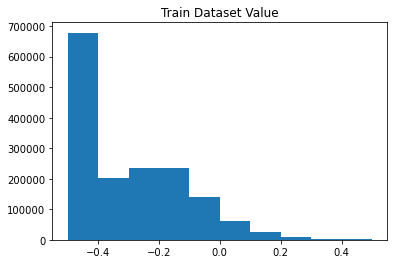

In [16]:
data = []
for i in range(len(trainds)):
    data += list((trainds[i][1].flatten().detach().cpu().numpy()))
plt.title("Train Dataset Value")
plt.hist(data)
plt.show()

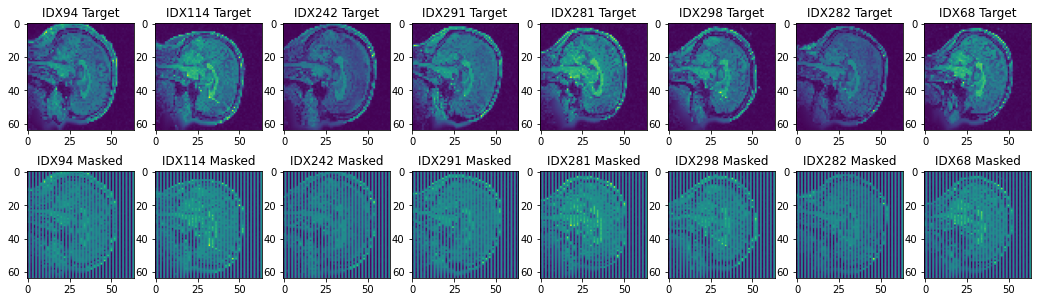

In [17]:
fig, axs = plt.subplots(2,8, figsize=(18, 5))
for i, n in enumerate(np.random.randint(0, len(trainds), size=(axs.shape[1]))):
    tgt = axs[0][i].imshow(trainds[n][1].permute(1,2,0), vmin=-0.5, vmax=0.5)
    axs[0][i].set_title("IDX%g Target"%n)
    msk = axs[1][i].imshow(trainds[n][0].permute(1,2,0), vmin=-0.5, vmax=0.5)
    axs[1][i].set_title("IDX%g Masked"%n)

# Model 

In [22]:
def make_model(nc=64):
    channels = (16, 32, 64, 128, 256)
    model =  UNet(
    spatial_dims=2,
    in_channels=nc,
    out_channels=nc,
    channels=channels,
    strides=tuple([2 for i in range(len(channels))]), 
    num_res_units=2,
    act="mish")
    model = nn.DataParallel(model) 
    return model.to(device)
print(make_model())

DataParallel(
  (module): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): Mish()
            )
          )
          (unit1): Convolution(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): Mish()
            )
          )
        )
        (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): SkipConnection(
        (submodule): Sequential(
          (0): ResidualUnit(
   

# Train and Validate Functions

In [23]:
def train(model, train_loader, optimizer, criterion, device="cpu"):
    """ Trains one epoch, validates with MSE """
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)

        # Backprop and optim step
        loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates model with criterion and MSE"""
    model.eval()

    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

In [24]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    all_train_losses, all_valid_losses, all_train_mse, all_valid_mse = [], [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            train_loss, train_mse = train(model, train_loader, optimizer, loss, device)
            valid_loss, valid_mse = validate(model, valid_loader, loss, device)
            
            all_train_losses.append(train_loss.item())
            all_train_mse.append(train_mse.item())
            all_valid_losses.append(valid_loss.item())
            all_valid_mse.append(valid_mse.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "train_loss": train_loss.item(), "train_mse":train_mse.item(), "valid_loss": valid_loss.item(), "valid_mse":valid_mse.item()}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 10))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(all_train_losses, label="train")
                axs[0].plot(all_valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(all_train_mse, label="train")
                axs[1].plot(all_valid_mse, label="valid")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE")

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx], vmin=-1, vmax=1)
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy(), vmin=-1, vmax=1)
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx], vmin=-1, vmax=1)
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            try:
                                v, T = loss.filters[0], loss.T
                            except:
                                loss_list = [str(l) for l in loss.losses]
                                awloss = loss.losses[loss_list.index("AWLoss()")]
                                v, T = awloss.filters[0], awloss.T
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        else:
                            pass


            plt.show()

# Training Setup

In [25]:
# Set training static parameters and hyperparameters
nepochs=1000                        
learning_rate=1e-3
batch_size=64                                        

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)
valid_loader = DataLoader(validds,
                        batch_size=1000,
                        shuffle=False,
                        num_workers=4)


# Sample for visualisation
x_sample, y_sample = validds[0]

# Joint Loss

In [26]:
from math import log, floor
class JointLoss(nn.Module):
    def __init__(self, losses, weights, norm=False):
        super(JointLoss, self).__init__()
        self.losses = losses
        self.weights = weights
        self.norm = norm

    def __str__(self):
        name = ""
        for l , w in zip(self.losses, self.weights):
            name += "{}(w={:.1E}) ".format(str(l)[:-2], w)
        return name[:-1]

    def scale(self, x):
        if self.norm:
            return x / 10**floor(log(x, 10))
        else:
            return x

    def forward(self, x, y):
        total_loss = 0.
        for l, w in zip(self.losses, self.weights):
            total_loss += w * self.scale(l(x, y))
        return total_loss

# Train MSE Loss



Training started ...


N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.28943556547164917, 'train_mse': 0.28943556547164917, 'valid_loss': 0.1770825833082199, 'valid_mse': 0.1770825833082199}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


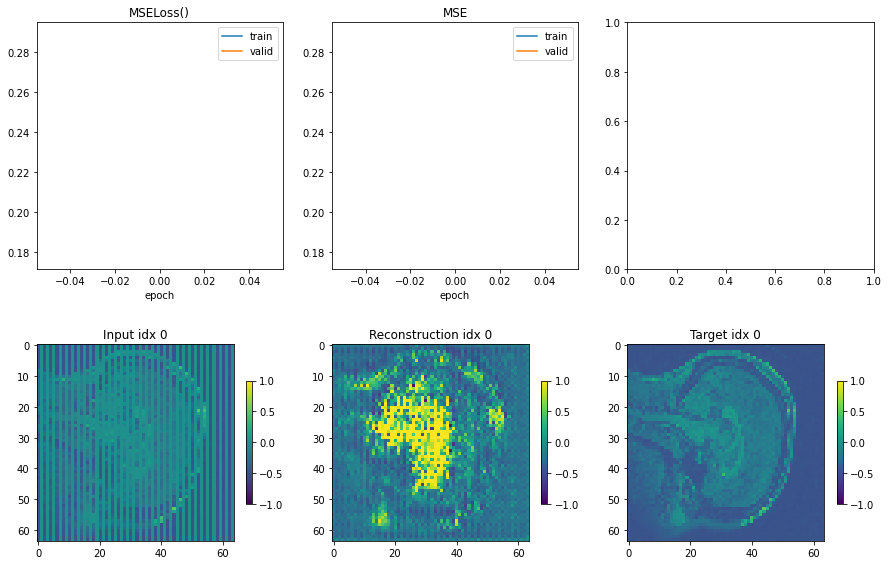

  7% (44 of 600) |#                      | Elapsed Time: 0:02:58 ETA:   0:37:59

In [27]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mseloss     = nn.MSELoss(reduction="mean")

train_model(model, optimizer, mseloss, train_loader,  valid_loader=valid_loader, nepochs=600, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

# Train AWLoss



Training started ...


N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.6967187523841858, 'train_mse': 0.6578677296638489, 'valid_loss': 0.6855111122131348, 'valid_mse': 0.6044077277183533}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


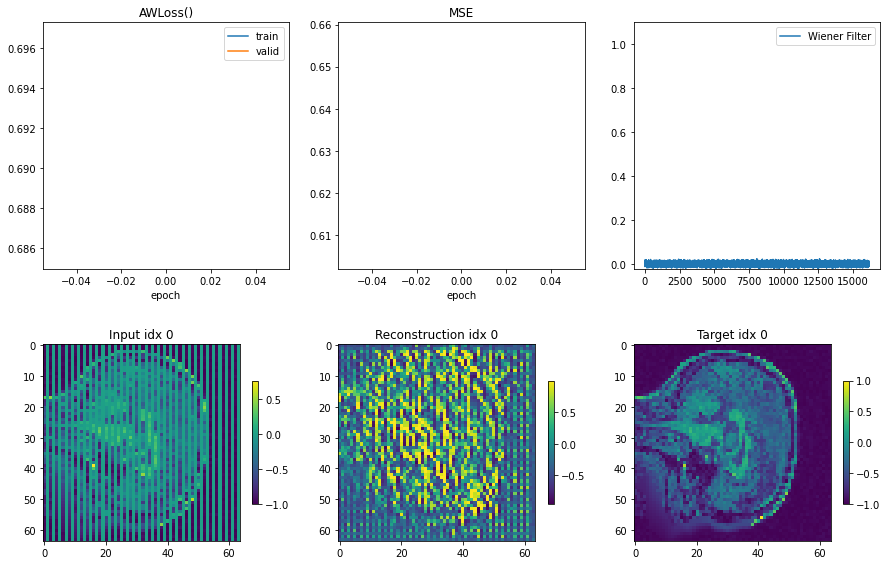

 25% (150 of 600) |#####                 | Elapsed Time: 0:11:29 ETA:   0:33:17


 {'epoch': 150, 'train_loss': 0.44211289286613464, 'train_mse': 0.06577914208173752, 'valid_loss': 0.544396698474884, 'valid_mse': 0.06901183724403381}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


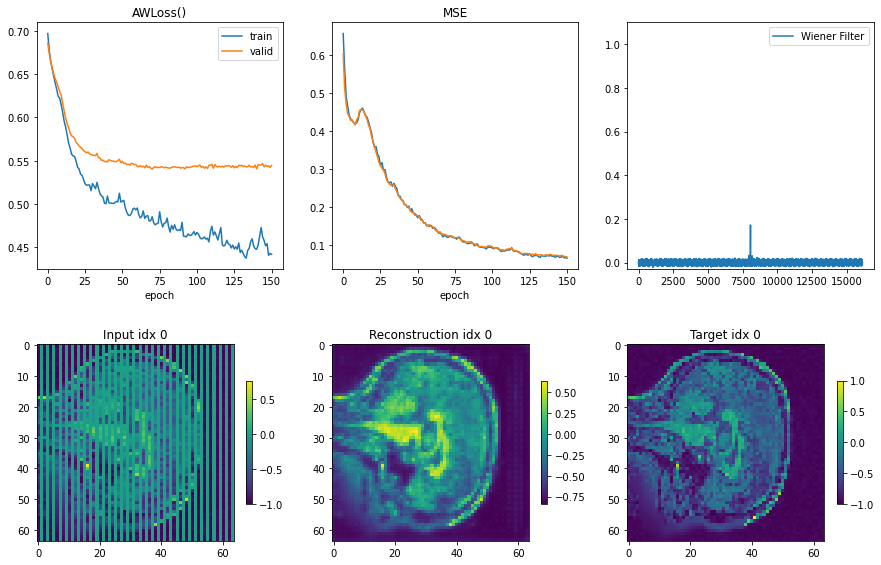

 50% (300 of 600) |###########           | Elapsed Time: 0:23:03 ETA:   0:23:23


 {'epoch': 300, 'train_loss': 0.4006469249725342, 'train_mse': 0.0450613759458065, 'valid_loss': 0.5433381795883179, 'valid_mse': 0.04976595938205719}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


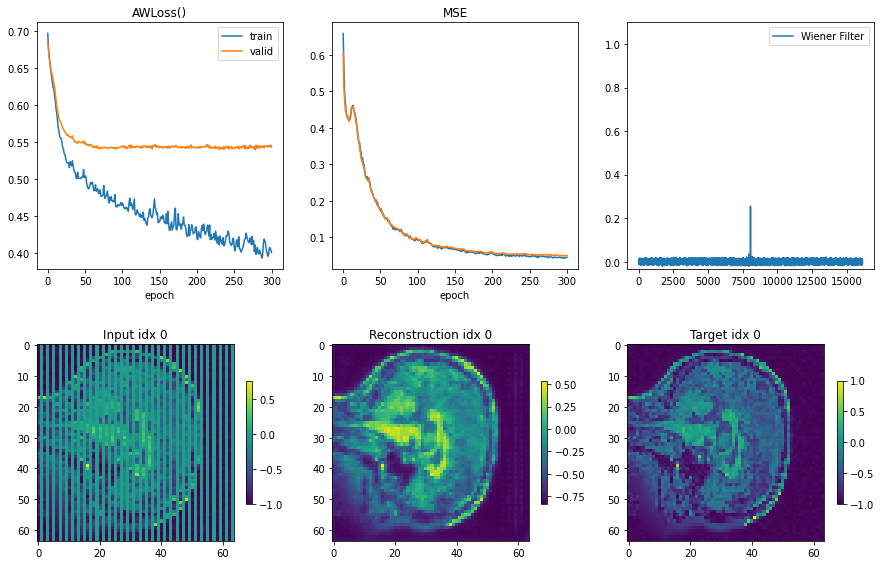

 75% (450 of 600) |################      | Elapsed Time: 0:34:34 ETA:   0:11:34


 {'epoch': 450, 'train_loss': 0.3736055791378021, 'train_mse': 0.039742469787597656, 'valid_loss': 0.5466117858886719, 'valid_mse': 0.04579746350646019}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


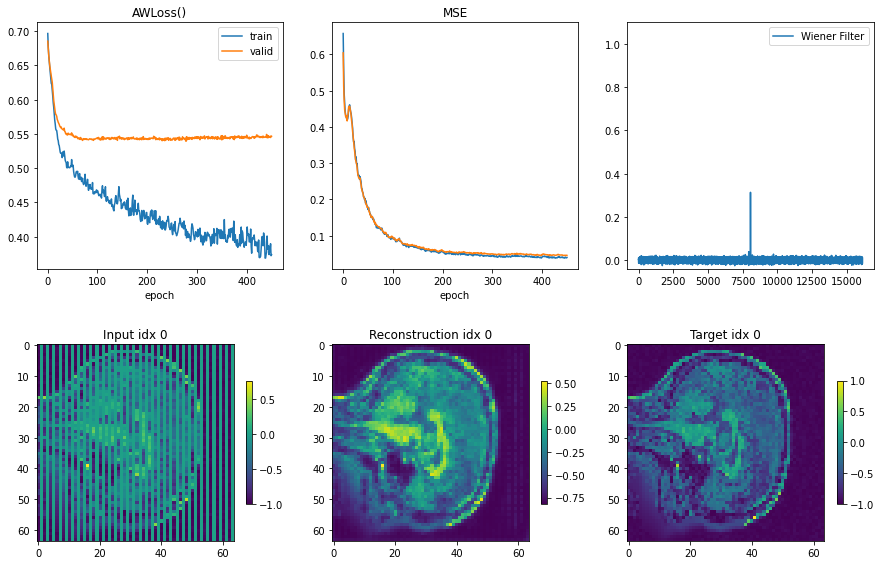

 99% (599 of 600) |##################### | Elapsed Time: 0:46:01 ETA:   0:00:04


 {'epoch': 599, 'train_loss': 0.37978610396385193, 'train_mse': 0.04110879451036453, 'valid_loss': 0.5456821918487549, 'valid_mse': 0.046885158866643906}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


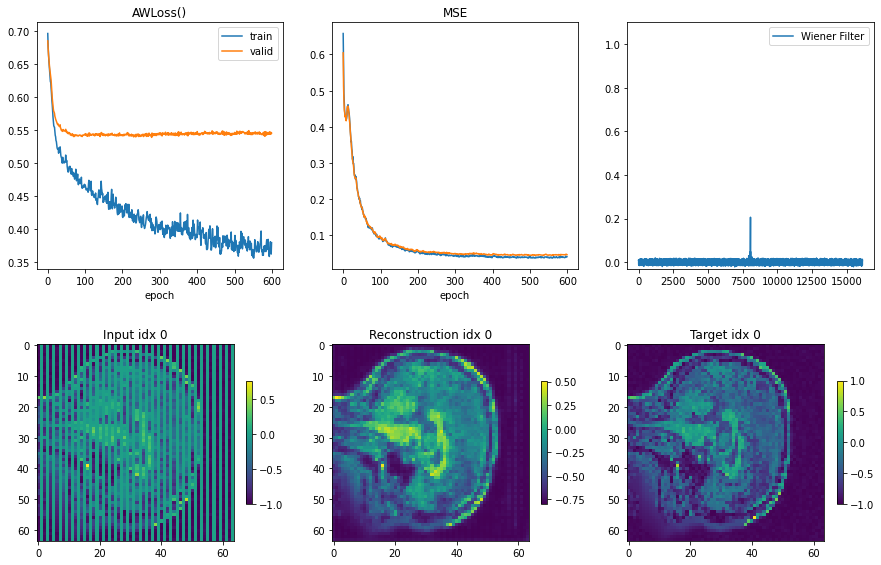

100% (600 of 600) |######################| Elapsed Time: 0:46:01 Time:  0:46:01


In [ ]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

awloss     = AWLoss(filter_dim=2, method="fft", reduction="mean", std=3e-4, store_filters="norm", epsilon=3e-15)

train_model(model, optimizer, awloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

# Train AWLoss + MSE



Training started ...


N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 1.4400843381881714, 'train_mse': 0.7375695705413818, 'valid_loss': 1.282846212387085, 'valid_mse': 0.585731565952301}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


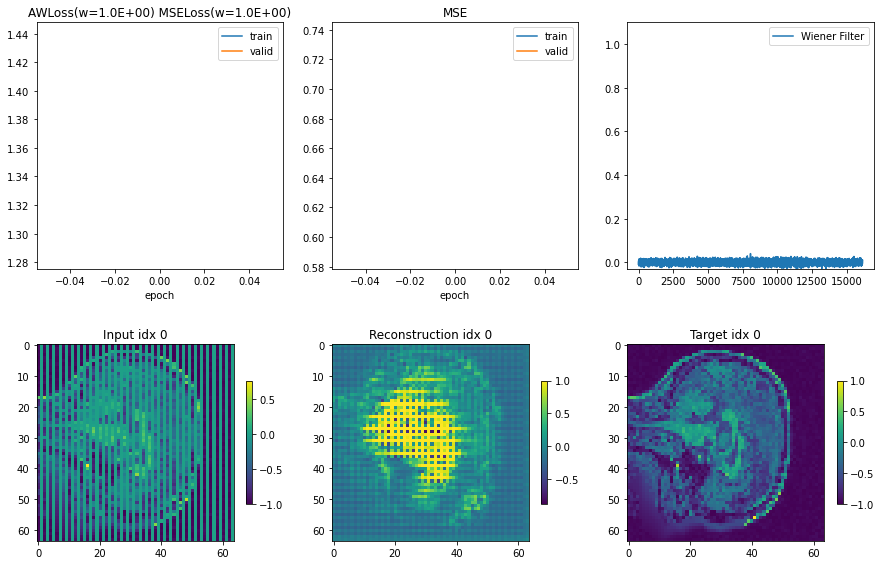

 25% (150 of 600) |#####                 | Elapsed Time: 0:12:41 ETA:   0:36:33


 {'epoch': 150, 'train_loss': 0.6041468381881714, 'train_mse': 0.10473542660474777, 'valid_loss': 0.680069088935852, 'valid_mse': 0.10772502422332764}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


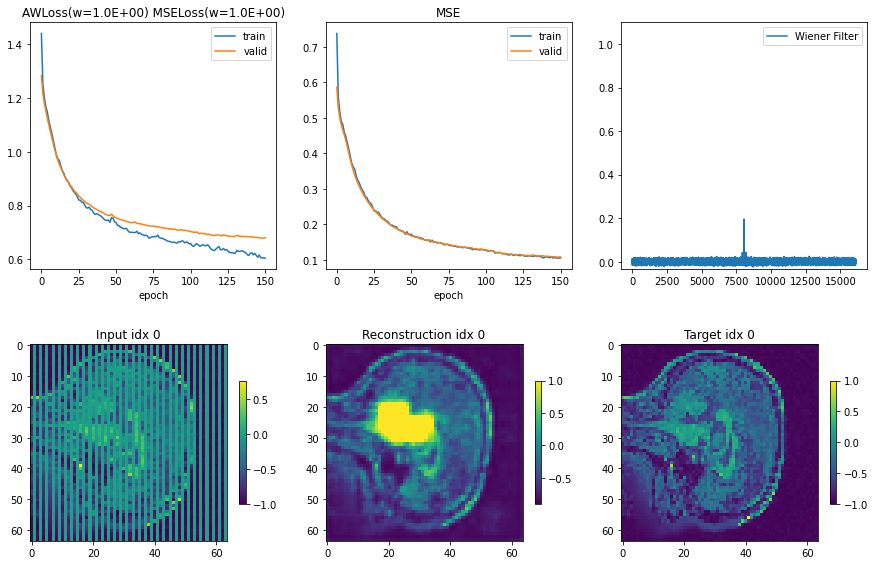

 50% (300 of 600) |###########           | Elapsed Time: 0:24:52 ETA:   0:25:02


 {'epoch': 300, 'train_loss': 0.5367810130119324, 'train_mse': 0.07396809011697769, 'valid_loss': 0.6450565457344055, 'valid_mse': 0.07803472131490707}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


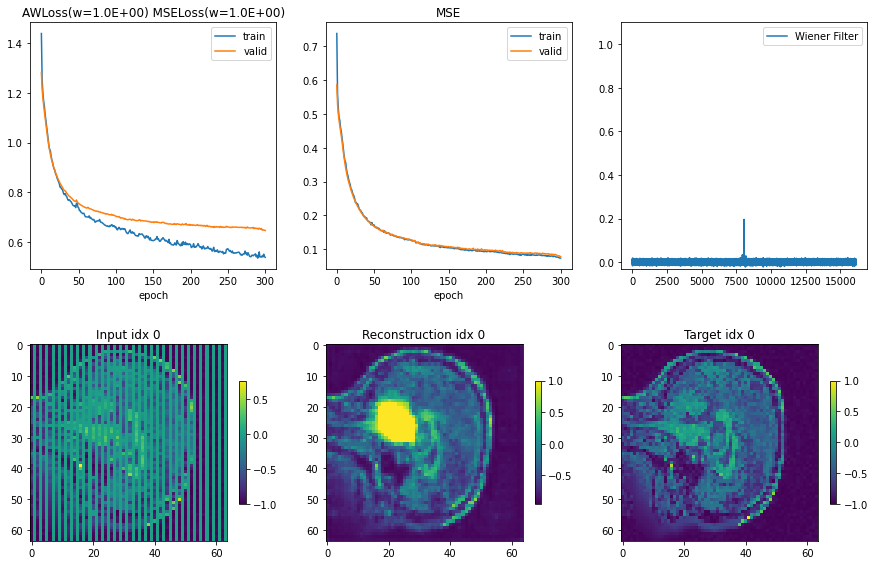

 75% (450 of 600) |################      | Elapsed Time: 0:36:46 ETA:   0:12:10


 {'epoch': 450, 'train_loss': 0.48058101534843445, 'train_mse': 0.05427824705839157, 'valid_loss': 0.624611496925354, 'valid_mse': 0.06272383034229279}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


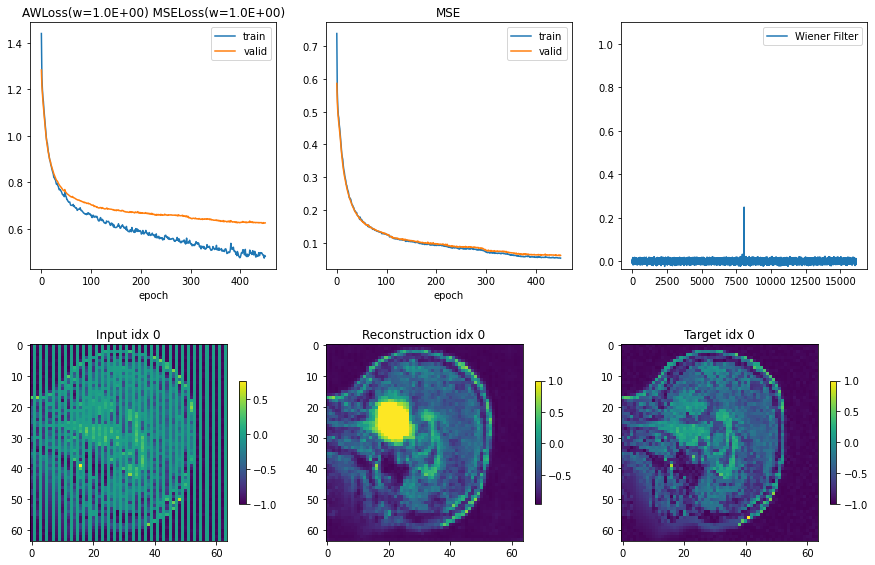

 99% (599 of 600) |##################### | Elapsed Time: 0:48:58 ETA:   0:00:04


 {'epoch': 599, 'train_loss': 0.4544355869293213, 'train_mse': 0.050554193556308746, 'valid_loss': 0.6242387294769287, 'valid_mse': 0.06127762049436569}
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
 argidx T, v:  8064 8064


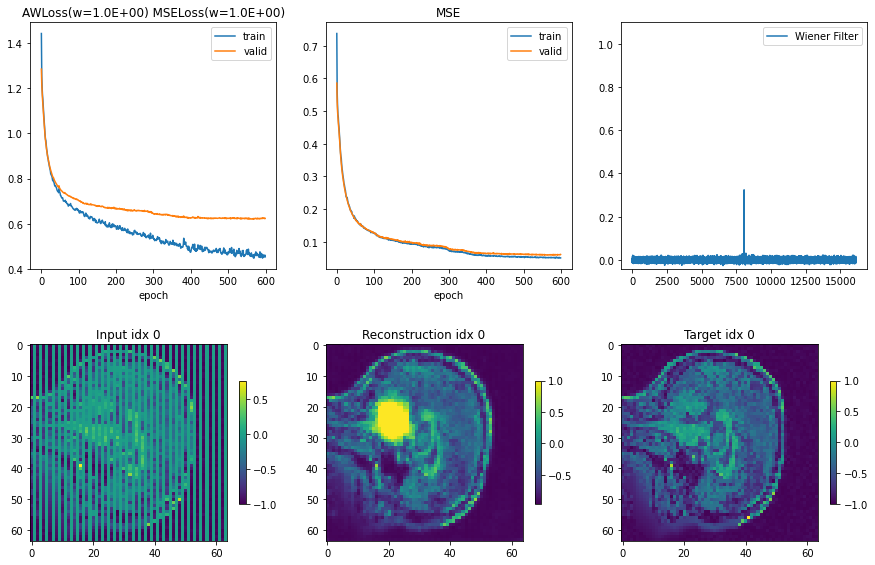

100% (600 of 600) |######################| Elapsed Time: 0:48:59 Time:  0:48:59


In [ ]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

awloss      = AWLoss(filter_dim=2, method="fft", reduction="mean", std=3e-4, store_filters="norm", epsilon=3e-15)
mseloss     = nn.MSELoss(reduction="mean")
combined    = JointLoss((awloss, mseloss), (1., 1.))

train_model(model, optimizer, combined, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)